## Part 1: Foundation: Data Exploration & Analysis - Understanding the raw data and uncovering initial insights about ride cancellations.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [47]:
print("--- Task 1: Data Loading ---")

--- Task 1: Data Loading ---


In [48]:
df = pd.read_csv("ncr_ride_bookings.csv")

In [49]:
print('--- Data Loading Successfully. First 5 rows:')
print("="*100)
print(df.head())
print("="*100)

--- Data Loading Successfully. First 5 rows:
         Date      Time    Booking ID   Booking Status   Customer ID  \
0  2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
1  2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
2  2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
3  2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
4  2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   

    Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT  \
0          eBike          Palam Vihar            Jhilmil       NaN       NaN   
1       Go Sedan        Shastri Nagar  Gurgaon Sector 56       4.9      14.0   
2           Auto              Khandsa      Malviya Nagar      13.4      25.8   
3  Premier Sedan  Central Secretariat           Inderlok      13.1      28.5   
4           Bike     Ghitorni Village        Khan Market       5.3      19.6   

   ...  Reason for cancelling by Customer

In [50]:
print("--- Task 2 Basic Dataset Information ---")
print('Dataset Shape: ',df.shape)
print('Dataset Columns: ',df.columns.tolist())
print("="*100)

--- Task 2 Basic Dataset Information ---
Dataset Shape:  (150000, 21)
Dataset Columns:  ['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Cancelled Rides by Customer', 'Reason for cancelling by Customer', 'Cancelled Rides by Driver', 'Driver Cancellation Reason', 'Incomplete Rides', 'Incomplete Rides Reason', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Payment Method']


In [51]:
df['Booking Status'].value_counts()

Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64

--- Task 3: Overall Cancellation Rate ---
The overall cancellation rate is: 25.00%


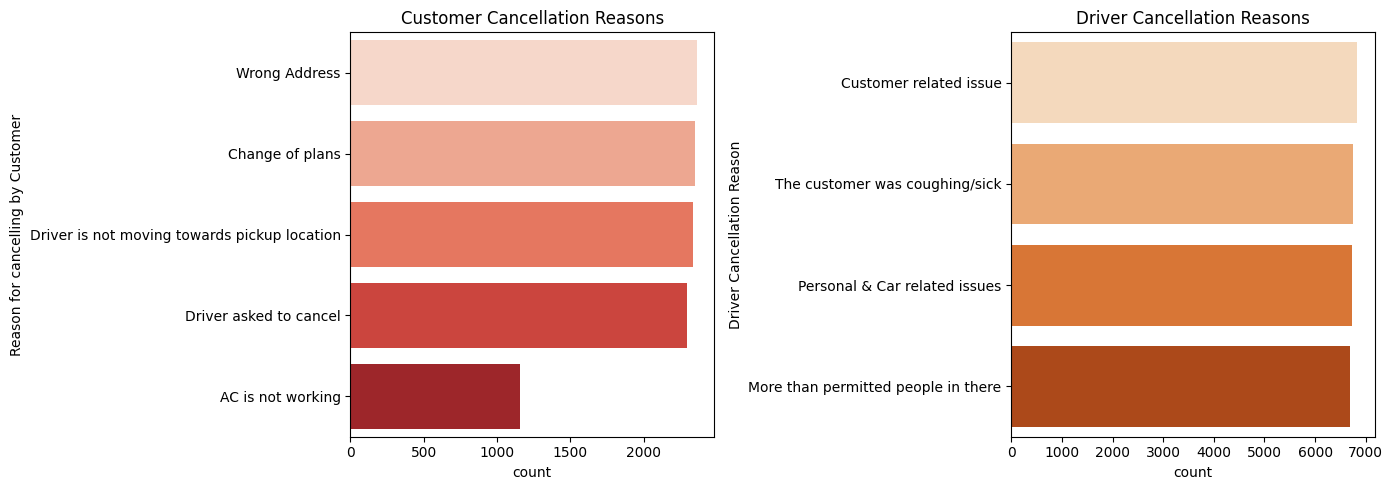

In [52]:
print('--- Task 3: Overall Cancellation Rate ---')
total_rides = len(df)
cancellation_statuses = ['Cancelled by Customer','Cancelled by Driver']
cancellation_rides = df[df['Booking Status'].isin(cancellation_statuses)]
cancelled_count = len(cancellation_rides)
ans = cancelled_count/total_rides
print(f'The overall cancellation rate is: {ans:.2%}')
print("="*100)

# 5️⃣ Cancellation Reasons (Customer & Driver)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.countplot(y='Reason for cancelling by Customer', data=df, order=df['Reason for cancelling by Customer'].value_counts().index, ax=axes[0], palette='Reds')
axes[0].set_title("Customer Cancellation Reasons")
sns.countplot(y='Driver Cancellation Reason', data=df, order=df['Driver Cancellation Reason'].value_counts().index, ax=axes[1], palette='Oranges')
axes[1].set_title("Driver Cancellation Reasons")
plt.tight_layout()
plt.show()

--- Task 4: Vehicle with Most Cancellations ---
The vehicle type with the most cancellations is:  Auto


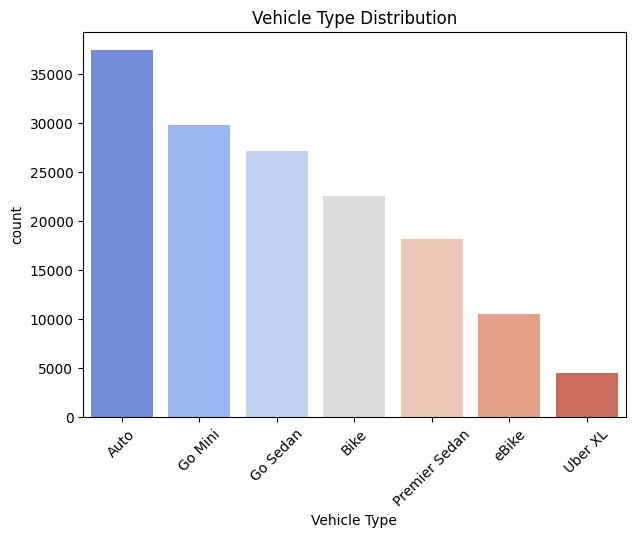

In [53]:
print('--- Task 4: Vehicle with Most Cancellations ---')
ans = cancellation_rides['Vehicle Type'].mode()[0]
print("The vehicle type with the most cancellations is: ",ans)
print("="*100)

plt.figure(figsize=(7,5))
sns.countplot(x='Vehicle Type', data=df, order=df['Vehicle Type'].value_counts().index, palette='coolwarm')
plt.title("Vehicle Type Distribution")
plt.xticks(rotation=45)
plt.show()

In [54]:
print('--- Task 5: Top Customer Cancellation Reason ---')
top_reason = df['Reason for cancelling by Customer'].mode()[0]
print('The most common reason for customer cancellations is: ',top_reason)
print('='*100)

--- Task 5: Top Customer Cancellation Reason ---
The most common reason for customer cancellations is:  Wrong Address


In [55]:
print('--- Task 6: Peak Cancellation Hour ---')
cancelled_df = df[df['Booking Status'].isin(cancellation_statuses)].copy()

cancelled_df['hour'] = cancelled_df['Time'].str.split(':').str[0].astype(int)

peak_hour = cancelled_df['hour'].mode()[0]
print(f'The hour with the most cancellations is: {peak_hour}:00 - {peak_hour+1}:00')
print("="*100)

--- Task 6: Peak Cancellation Hour ---
The hour with the most cancellations is: 18:00 - 19:00


In [56]:
df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method'],
      dtype='object')

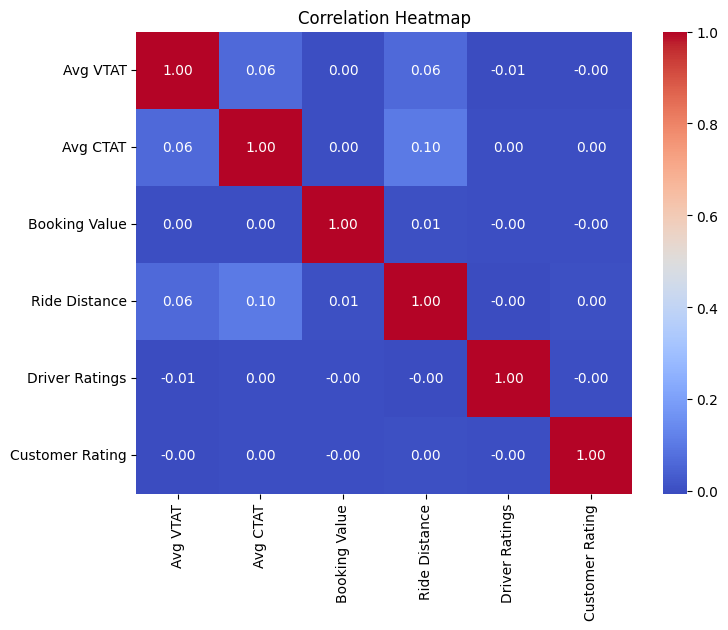

In [57]:
num_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Part 2 - Data Cleaning and Preprocessing
---

### 1) Create Target Variable: Engineer a new binary column named is_cancelled. This will be our target for prediction.

- A ride should be marked as 1 (cancelled) if its Booking Status is 'Cancelled by Customer', 'Cancelled by Driver', or 'No Driver Found'.
- A ride should be marked as 0 (not cancelled/completed) if its Booking Status is 'Completed'.
- All other ride statuses (e.g., 'Incomplete') are not relevant for our prediction task and should be removed from the dataset.

In [58]:
cancellation_statuses = ['Cancelled by Customer', 'Cancelled by Driver', 'No Driver Found']

df['is_cancelled' ] = np.where(
    df['Booking Status'].isin(cancellation_statuses), 1,
        np.where(df['Booking Status' ] == 'Completed', 0, -1)
        )

new_df = df[df['is_cancelled']!=-1].copy()

### 2) Engineer New Features: Create a new column hour_of_day by extracting the hour from the Time column. This will help the model learn time-based patterns.

In [59]:
new_df['hour_of_day'] = pd.to_datetime(new_df['Time'], format='%H:%M:%S').dt.hour

### 3) Handle Missing Data (Corrected Logic): 
- The dataset uses the string 'null' for missing values. First, convert these to a standard format (like NaN).
- Then, instead of dropping rows, impute (fill) the missing values in the Avg VTAT and Avg CTAT columns with 0.
- This is critical because cancelled rides often lack arrival time data, and filling with 0 preserves these important examples for the model.

In [60]:
new_df.replace('null',np.nan,inplace=True)

In [61]:

new_df['Avg VTAT' ] = new_df['Avg VTAT' ].fillna(0)
new_df['Avg CTAT' ] = new_df[ 'Avg CTAT' ].fillna(0)

new_df['Avg VTAT'] = pd.to_numeric(new_df[ 'Avg VTAT' ])
new_df['Avg CTAT' ] = pd.to_numeric(new_df['Avg CTAT' ])

print(f"Imputation complete. Rows remaining: {len(new_df)}")

Imputation complete. Rows remaining: 141000


### 4) Remove Unnecessary Columns: Drop columns that are irrelevant, redundant, or would cause "data leakage" (i.e., they reveal the answer to the model). The following columns must be removed:

- Leakage Columns: Booking Status, Cancelled Rides by Customer, Reason for cancelling by Customer, Cancelled Rides by Driver, Driver Cancellation Reason, Incomplete Rides, Incomplete Rides Reason.
- Post-Ride Info: Ride Distance, Booking Value, Driver Ratings, Customer Rating (these are only known after a ride is completed).
- High Cardinality/ID Columns: Booking ID, Customer ID.
- Redundant Columns: Date, Time (since we have already extracted the hour_of_day).

In [62]:
new_df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method', 'is_cancelled',
       'hour_of_day'],
      dtype='object')

In [63]:
columns_to_drop = ['Booking Status', 'Cancelled Rides by Customer', 'Reason for cancelling by Customer',
'Cancelled Rides by Driver', 'Driver Cancellation Reason', 'Incomplete Rides',
'Incomplete Rides Reason', 'Ride Distance', 'Booking Value', 'Driver Ratings',
'Customer Rating', 'Booking ID', 'Customer ID', 'Date', 'Time']

cols_to_drop_existing = [col for col in columns_to_drop if col in new_df.columns]
new_df.drop(columns=cols_to_drop_existing,inplace=True)

In [64]:
new_df.columns

Index(['Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Payment Method', 'is_cancelled', 'hour_of_day'],
      dtype='object')

In [65]:
new_df.to_csv('clean_uber_rides.csv')

# Part 3 - Building and Evaluating the Model
---

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### 1) Prepare Data for Modeling:
- Load the clean_uber_rides_2024.csv dataset.
- Separate the dataset into features (X) and the target variable (y, which is the is_cancelled column).
- Convert categorical features into a numerical format using One-Hot Encoding.

In [67]:
clean_df = pd.read_csv("clean_uber_rides.csv")

In [68]:
X = clean_df.drop(columns='is_cancelled')
y = clean_df['is_cancelled']

In [69]:
X_encoded = pd.get_dummies(X,drop_first=True)

### 2) Split the Data:
- Divide the prepared data into a training set and a testing set using a stratified split to ensure both sets have a representative number of cancelled and completed rides.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42,stratify=y)

### 3) Train a Classification Model:
- Instantiate and train a DecisionTreeClassifier model. This is a powerful and intuitive model that learns a set of explicit ′if-then-else′ rules, making its predictions easy to understand.

In [71]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

### 4) Evaluate Model Performance:
- Use the trained model to make predictions on the testing set.
- Calculate the accuracy of the model to measure its overall performance.

In [72]:
y_pred = model.predict(X_test)

In [73]:
accuracy = accuracy_score(y_test,y_pred)
print(f'Model Evaluation Complete, Model Accuracy: {accuracy:.4f}')

Model Evaluation Complete, Model Accuracy: 1.0000


### 5) Create a Prediction Pipeline:
- Build a main function that orchestrates all the steps above and returns the fully trained DecisionTreeClassifier model and the feature columns it expects.

In [74]:
trained_model = model
model_columns = X_encoded.columns.tolist()

In [75]:
if trained_model and model_columns:
    print("\n --- Prediction Example ---\n")
    sample_ride = {
        'Vehicle Type': 'Go Sedan',
        'Pickup Location': 'Khandsa',
        'Drop Location': 'Malviya Nagar',
        'Avg VTAT': 13.4,
        'Avg CTAT': 25.8,
        'Payment Method': 'UPI',
        'hour_of_day' : 8
        }
print("Sample ride data ",sample_ride)


 --- Prediction Example ---

Sample ride data  {'Vehicle Type': 'Go Sedan', 'Pickup Location': 'Khandsa', 'Drop Location': 'Malviya Nagar', 'Avg VTAT': 13.4, 'Avg CTAT': 25.8, 'Payment Method': 'UPI', 'hour_of_day': 8}


In [76]:
sample_df = pd.DataFrame([sample_ride])
sample_df

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Payment Method,hour_of_day
0,Go Sedan,Khandsa,Malviya Nagar,13.4,25.8,UPI,8


In [77]:
sample_encoded = pd.get_dummies(sample_df)
sample_encoded

,Avg VTAT,Avg CTAT,hour_of_day,Vehicle Type_Go Sedan,Pickup Location_Khandsa,Drop Location_Malviya Nagar,Payment Method_UPI
0,13.4,25.8,8,True,True,True,True


In [78]:
sample_aligned = sample_encoded.reindex(columns=model_columns,fill_value=0)

In [79]:
prediction = trained_model.predict(sample_aligned)

In [80]:
prediction_proba = trained_model.predict_proba(sample_aligned)

In [81]:
result = "Cancelled" if prediction[0] == 1 else "Completed"
print(f"Predicted outcome: {result}")
print(f"Prediction probability (0=Completed, 1=Cancelled): {prediction_proba[0]}")

Predicted outcome: Completed
Prediction probability (0=Completed, 1=Cancelled): [1. 0.]


#### Our model predicted "Completed" because:
    The probability for class 0 (Completed) = 1.0
    The probability for class 1 (Cancelled) = 0.0
    So the model is 100% confident the order will be Completed.